In [525]:
%load_ext autoreload
%autoreload 2

# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

from etl.extract import ProjectZero

# import projectzero data
from etl.extract import ProjectZero
data = ProjectZero().get_data()

# df_model instance
df_model = data['hz_model'].copy()
df_nyc = data['ext_nyc']
df_seattle = data['ext_seattle'].copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\hramzan\Documents\GitHub\project_zero\etl\extract.py:24: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [526]:
features = [
    'PrimaryPropertyType',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
    'PropertyGFAParking',
    'Electricity(kWh)']

df_seattle = df_seattle[features]

# drop duplicates
df_seattle.dropna(inplace=True)

high_correlation = [
    'Hotel',
    'Low-Rise Multifamily',
    'Mid-Rise Multifamily',
    'High-Rise Multifamily',
    'K-12 School',
    'College/University',
    'Large Office',
    'Retail Store'
    ]

df_seattle = df_seattle[df_seattle.PrimaryPropertyType.isin(high_correlation)] 

# Removing outliers for 'College/University' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'College/University') & (df_seattle['PropertyGFABuilding(s)'] >= 2200000))]

# Removing outliers for 'Retail Store' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'Retail Store') & (df_seattle['PropertyGFABuilding(s)'] >= 200000))]

In [527]:
#
df_seattle = df_seattle[~((df_seattle['Electricity(kWh)'] > 10000000) | (df_seattle['PropertyGFABuilding(s)'] > 800000))]

#high rise outliers
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'High-Rise Multifamily') & (df_seattle['Electricity(kWh)'] >= 5000000))]


In [528]:
import plotly.express as px

px.scatter(df_seattle, x='PropertyGFABuilding(s)', y='Electricity(kWh)', color='PrimaryPropertyType')


In [529]:
from sklearn.preprocessing import OrdinalEncoder

# finding string features to encode
nan_features = [i for i in df_seattle.columns if df_seattle[i].dtype == 'object']

# Instantiate Ordinal Encoder
ordinal_encoder = OrdinalEncoder()

# Fit to features
df_encoded = df_seattle.copy()
ordinal_encoder.fit(df_encoded[nan_features])

# Transforming categories into ordered numbers
df_encoded[nan_features] = ordinal_encoder.transform(df_encoded[nan_features])


In [530]:
from sklearn.preprocessing import StandardScaler

# drop property type columns
# df_seattle.drop(columns='PrimaryPropertyType', inplace=True)

# instantiate scaler
s_scaler = StandardScaler()

# instantiate scaled df before transform
df_scaled = df_encoded.copy()

# define numerical features 
numerical_features = list(df_scaled.columns)
numerical_features.remove('Electricity(kWh)') # remove target before scaling

# fit scaler
s_scaler.fit(df_scaled[numerical_features])

# apply tranform to features
df_scaled[numerical_features] = s_scaler.transform(df_scaled[numerical_features])

In [531]:
# import model type
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Instantiate model 
sgd_regressor = SGDRegressor(random_state=6, alpha=0.1)

# define x and y 
features = list(df_scaled.columns)
features.remove('Electricity(kWh)')

X = df_scaled[features]
y = df_scaled['Electricity(kWh)']

# train model 

scores = cross_val_score(sgd_regressor, X, y, cv=3)
scores.mean()

0.5420561246768228

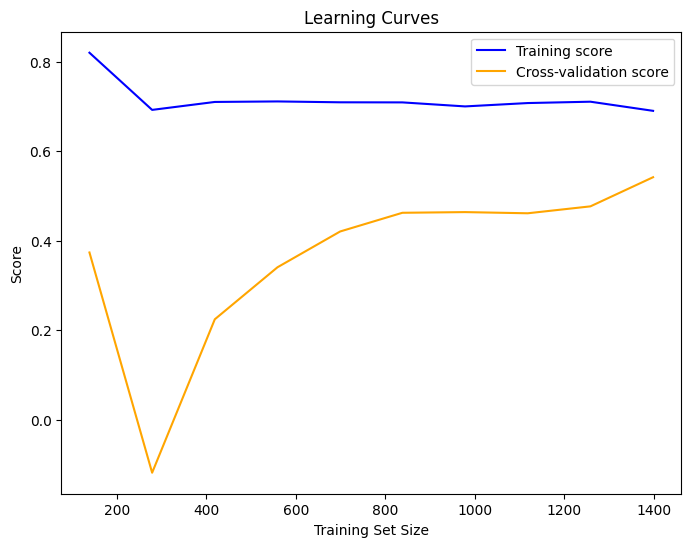

In [532]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator, X=X, y=y, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, color="blue", label="Training score")
    plt.plot(train_sizes, test_mean, color="orange", label="Cross-validation score")
    plt.title("Learning Curves")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

# Usage:
plot_learning_curve(sgd_regressor, X, y)


In [533]:
# prediction function 
def new_prediction(values: list, features: list):
    prediction = {}

    for key, value in zip(features, values):
        prediction[key] = value

    return pd.DataFrame(prediction, index=[0])

In [534]:
new_values = ['Hotel',23,335066,12000]
new_building = new_prediction(new_values, features)

In [535]:
df_scaled.PrimaryPropertyType.unique()[0]

-1.9757616457083595

In [536]:
# train model 
sgd_regressor.fit(X, y)

# Encode Features
new_building[nan_features] = ordinal_encoder.transform(new_building[nan_features])

# Scale the new data using the same scaler used for the training data
new_building[numerical_features] = s_scaler.transform(new_building[numerical_features])

# predict new_building
prediction = sgd_regressor.predict(new_building)
print(f'prediction: {int(prediction[0])}')

new_building

prediction: 3336673


,PrimaryPropertyType,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking
0,-1.975762,3.844436,3.192791,0.054411


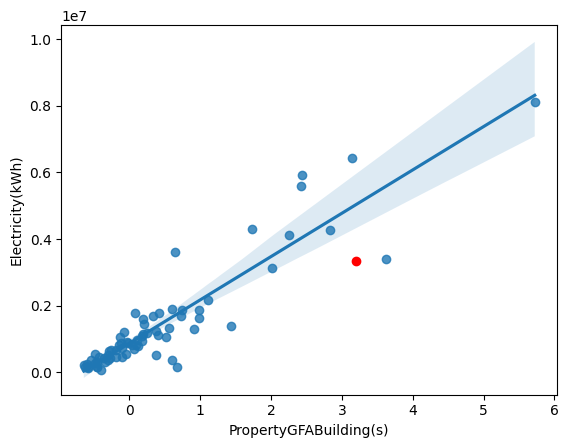

In [537]:
import seaborn as sns
import matplotlib.pyplot as plt

hotel_code = df_scaled.PrimaryPropertyType.unique()[0]

# Filter the data for a specific property type
property_type = hotel_code # Replace with the property type you want to visualize
subset_data = df_scaled[df_scaled['PrimaryPropertyType'] == property_type]

# Create a regression plot
sns.regplot(data=subset_data, x='PropertyGFABuilding(s)', y='Electricity(kWh)')

# Scatter plot for predicted values
plt.scatter(new_building['PropertyGFABuilding(s)'], prediction, color='red', label='Predicted')